# UCI Heart Disease Demo

In [38]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method
from core import recourse_iterator
from data import data_adapter as da
from models import model_utils
from core import utils
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

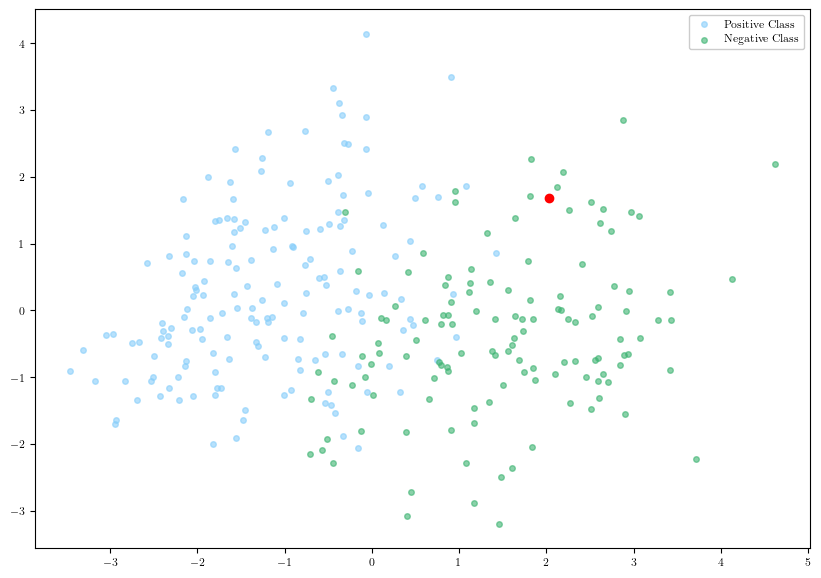

In [90]:
class ProbaLR:
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        y = self.model.predict(X)
        return y[:,None]


dataset, preprocessor = da.load_uci_heart_disease_dataset()

X = preprocessor.transform(dataset.drop('num', axis=1)).copy().to_numpy()
y = dataset['num'].copy().to_numpy()

model = linear_model.LinearRegression()
model.fit(X, y)
model = ProbaLR(model)

prob = model.predict_proba(X)[:,0]
dataset.loc[:,'num'] = 0
dataset.loc[prob >= 0.5,'num'] = 1

poi = utils.random_poi(dataset, column='num', label=0)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('num', axis=1)).to_numpy(),
    dataset['num'].to_numpy(),
    positive_label = 1
).set_poi(preprocessor.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

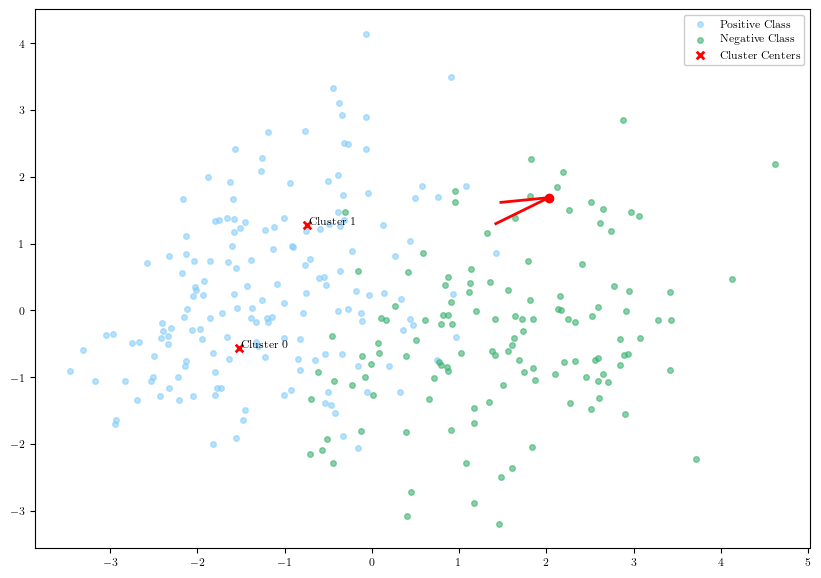

In [91]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    preprocessor,
    dataset,
    label_column='num',
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = preprocessor.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('num', axis=1)).to_numpy(),
    dataset['num'].to_numpy(),
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

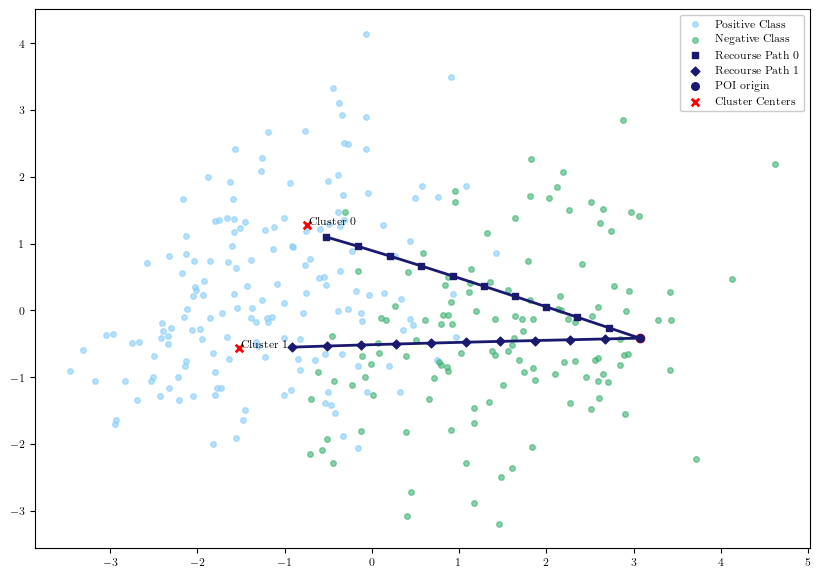

In [89]:
check_certainty = recourse_iterator.wrap_model(model)

mrmc = mrmc_method.MRMC(
    k_directions,
    preprocessor,
    dataset,
    label_column='num',
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    preprocessor.transform(dataset.drop('num', axis=1)).to_numpy(),
    dataset['num'].to_numpy(),
)

poi = utils.random_poi(dataset, column='num', label = 0)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    preprocessor,
    certainty_cutoff=None,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

transformed_paths = [preprocessor.transform(path) for path in paths]

display.do_pca().set_poi(preprocessor.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?
Pay attention to binary columns:
* sex
* fbs
* restecg
* exang
* thal

and ordinal columns:
* slope
* ca

The recourse may try to adjust these slowly when in actuality only discrete adjustments are allowed.

In [85]:
paths[0]

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,45.000000,1.000000,110.000000,264.000000,0.000000,0.000000,132.000000,0.000000,1.200000,2.000000,0.000000,1.000000
1,46.670859,0.882857,112.813001,263.973952,0.012053,0.072072,134.556245,0.019590,1.116323,1.935788,0.037161,0.864561
2,48.315772,0.764789,115.605129,263.909338,0.023339,0.143912,137.159869,0.038425,1.032355,1.871282,0.073589,0.728849
3,49.923191,0.645400,118.373256,263.802239,0.033601,0.215399,139.831549,0.056160,0.947908,1.806149,0.108971,0.592979
4,51.476190,0.524179,121.117505,263.654591,0.042490,0.286444,142.599102,0.072282,0.862592,1.739758,0.142810,0.457287
5,52.950430,0.400615,123.847330,263.492480,0.049539,0.357312,145.498917,0.086017,0.775565,1.670885,0.174334,0.322643
6,54.312405,0.274653,126.592882,263.415154,0.054125,0.429676,148.578845,0.096160,0.685073,1.597143,0.202432,0.191192
7,55.517748,0.148239,129.422578,263.709382,0.055362,0.509512,151.908869,0.100571,0.587793,1.513517,0.225925,0.068435
8,56.478907,0.034887,132.466818,265.364898,0.051511,0.618273,155.606991,0.093279,0.476172,1.404190,0.244794,-0.024226
9,55.611934,0.189221,130.374550,268.818833,0.051681,0.634159,153.076584,0.076633,0.519856,1.407015,0.238175,0.131127


In [86]:
paths[1]

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,45.000000,1.000000,110.000000,264.000000,0.000000,0.000000,132.000000,0.000000,1.200000,2.000000,0.000000,1.000000
1,45.606566,0.980139,112.661841,257.565864,0.015689,0.048622,138.209312,0.008643,1.061643,1.876351,0.027308,0.872842
2,46.197350,0.961050,115.290967,251.261275,0.029735,0.095802,144.362320,0.016830,0.919931,1.748799,0.053927,0.745086
3,46.741001,0.943224,117.862949,245.173794,0.041502,0.140510,150.407316,0.024258,0.774417,1.615553,0.079527,0.615297
4,47.178958,0.927627,120.331044,239.450698,0.050045,0.180764,156.255641,0.030446,0.625653,1.474911,0.103492,0.480352
5,47.421326,0.916440,122.619565,234.361265,0.053760,0.212435,161.749605,0.034538,0.476172,1.325996,0.124261,0.334953
6,47.322295,0.915341,124.600464,230.417109,0.049242,0.224796,166.628084,0.034550,0.330818,1.170178,0.136237,0.173073
7,46.153112,0.951434,125.455598,229.570276,0.021753,0.155879,169.869386,0.020824,0.199285,1.031025,0.098833,0.005531
8,46.463135,0.926983,123.015613,230.023636,0.043858,0.153683,166.629143,0.028829,0.271567,1.177066,0.094721,0.193532
9,46.944888,0.928742,125.867268,229.134899,0.029726,0.219985,168.754913,0.028085,0.260037,1.038132,0.144794,0.007776
